In [1]:
import torch
from torchvision.io import read_image, ImageReadMode, write_video
import torchvision.transforms as T
from random import randint
from IPython.display import clear_output
import numpy as np
import pylab as pl
import wandb

from src import *

In [2]:
N_CHANNELS = 15        # Number of CA state channels
TARGET_PADDING = 0    # Number of pixels used to pad the target image border
TARGET_SIZE = 40       # Size of the target emoji
IMAGE_SIZE = TARGET_PADDING+TARGET_SIZE
BATCH_SIZE = 4
N_ITERS = 45           # Iterations before applying the loss
POOL_SIZE = 512
CELL_FIRE_RATE = 0.5
VIRUS_PROPORTION = 0.1

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# Load the growing CA part
old_CA = NeuralCA(device=device)
old_CA.load("Pretrained_models/firework_growing.pt")

for param in old_CA.parameters():
   param.requires_grad = False

Successfully loaded model!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


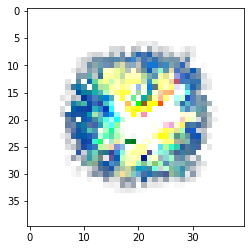

In [5]:
# Starting state
def generator(n, device):
    return make_seed(n, N_CHANNELS-1, IMAGE_SIZE, alpha_channel=3, device=device)

generator = VirusGenerator(N_CHANNELS, IMAGE_SIZE, 1, old_CA, iter_func=ExponentialSampler(max=50))
pool = SamplePool(POOL_SIZE, generator)
imshow(pool[0])

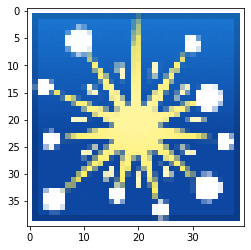

In [6]:
# Imports the target emoji
target = read_image("images/firework.png", ImageReadMode.RGB_ALPHA).float()
target = T.Resize((TARGET_SIZE, TARGET_SIZE))(target)
target = RGBAtoFloat(target)

imshow(target)

In [7]:
# Send target to device
target = target.to(device)

In [8]:
# Load the virus CA part
new_CA = NeuralCA(device=device)
new_CA.load("Pretrained_models/mask 70% persist.pt")
model = VirusCA(old_CA, new_CA, mutation_probability=0.7)

Successfully loaded model!


In [9]:
# Train the model
wandb.watch(model, log_freq=64)

optimizer = torch.optim.Adam(model.new_CA.parameters(), lr=1e-3 * 0.5)
criterion = NCALoss(pad(target, TARGET_PADDING))
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[40,80], gamma=0.3)
model.train_CA(optimizer, criterion, pool, n_epochs=120, scheduler=scheduler, kind="persist", skip_update=4)

epoch: 120
avg loss: 0.0017255951024708338


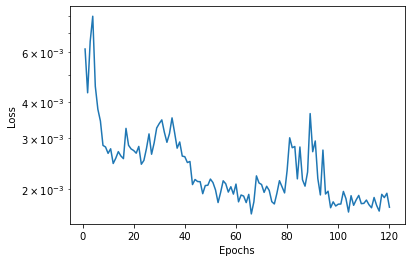

In [25]:
# Show losses
model.plot_losses()

In [26]:
model.new_CA.save("Pretrained_models/mask 70% persist v2.pt")

Successfully saved model!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


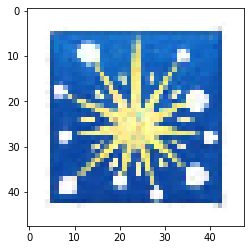

In [19]:
# Show a sample from the pool images
imshow(pool.sample(1)[0][0])

In [27]:
# Save the model and upload it to wandb
#model.new_CA.save("Pretrained_models/virus 40% persist.pt")

wandb.log({"state_dict": model.new_CA.state_dict()})
wandb.save("Pretrained_models/virus 70% persist switch.pt")

['/home/lettera/Desktop/neural_cellular_automata/pytorch_ca/wandb/run-20211002_222136-3oek1x9e/files/Pretrained_models/mask 70% persist v2.pt']

In [28]:
# Upload pool images to wandb
imgs = []

for i in range(12):
    img = np.asarray(pool.sample(1)[0][0].cpu().permute(1, 2, 0)[:, :, :4])
    img = wandb.Image(img)
    imgs.append(img)

wandb.log({"pool samples": imgs})

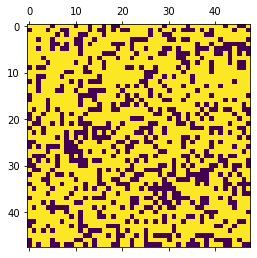

In [29]:
# Show the virus cell mask
pl.matshow(model.new_cells.cpu()[0,0])

In [30]:
# Upload mask to wandb
wandb.log({"mask": wandb.Image(model.new_cells.cpu()[0,0])})

In [33]:
# Make a switch video
_ , _ = switch_video(old_CA, model, fname="prova.mp4")

In [32]:
# Upload the evolution video to wandb
wandb.log({"video": wandb.Video("prova.mp4", "video", fps=10, format="mp4")})

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


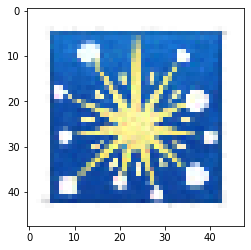

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


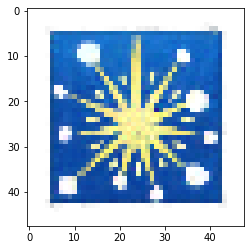

In [34]:
# Evolve the CA for 200 iters and plot it
x, _ = pool.sample(1)
imshow(x[0])
x = x.to(device)
model.update_cell_mask(x)

with torch.no_grad():
    for i in range(1000):
        x = model.forward(x)

imshow(x[0].cpu())

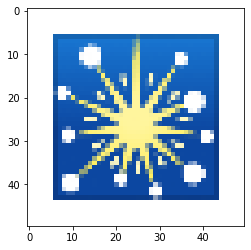

In [21]:
# Plots the true emoji
imshow(TraintoFloat(pad(target, 10, -1)))

In [2]:
wandb.finish()